In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from cmcrameri import cm
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm

from src.AnalysisFunctions import *
from src.Segmentation3D import get_voxel_size_35mm
from src.HolomonitorFunctions import get_pixel_size
from src.FormatConversions import import_holomonitor_stack, import_tomocube_stack

In [3]:
# experimental parameters
vox_to_um = get_voxel_size_35mm()
pix_to_um = get_pixel_size()

dt = 4 # h
dt_holo = 12 # frames per hour
dt_tomo = 4  # frames per hour
rblur_holo = 0.75
rblur_tomo = 0.9
#holomonitor_scaling = 100

fmin_holo = [188, 1, 1, 130, 1, 1] 
fmax_holo = [225, 181, 145, 181, 145, 145]

fmin_tomo = 1
fmax_tomo = 40

In [ ]:
# Import Holomonitor
holo_dir = ["../../data/Holomonitor/MDCK_01.03.2024/",
            "../../data/Holomonitor/MDCK_19.03.2024/",
            "../../data/Holomonitor/MDCK_16.05.2024/"]

# holo_files = ["A1-1", "B1-1", "A1-9", "A1-12", "A1-13", "B1-11"]
# holo_paths = [holo_dir[0], holo_dir[0], holo_dir[1], holo_dir[1], holo_dir[1], holo_dir[1]]

holo_files = ["B2-5", "A1-9", "A1-12", "A1-18", "B1-11", "B1-9"]
holo_paths = [holo_dir[0], holo_dir[1], holo_dir[1], holo_dir[1], holo_dir[1], holo_dir[2]]

# Import Tomocube
tomo_files = ["250210.113448.MDCK dynamics.001.MDCK B.A2"]
tomo_paths  = ["../../data/Tomocube/MDCK_10.02.2025/A2P1/"]

holo_colors = sns.color_palette("mako", as_cmap=False)
tomo_colors = sns.color_palette("flare", as_cmap=False)
h0, = plt.plot([0], marker='None', linestyle='None', label='dummy-tophead');

In [5]:
# Holomonitor
# settings
stepsize = 6
steps = int((np.max(fmax_holo) - np.min(fmin_holo)) / stepsize)

density_pixel = np.zeros([len(holo_paths), steps])
density_disk = np.zeros([len(holo_paths), steps])
density_cell = np.zeros([len(holo_paths), steps])

h_mean_pixel = np.zeros([len(holo_paths), steps])
h_mean_disk  = np.zeros([len(holo_paths), steps])
h_mean_cell  = np.zeros([len(holo_paths), steps])

fluctuation_pixel = np.zeros([len(holo_paths), steps])
fluctuation_disk  = np.zeros([len(holo_paths), steps])
fluctuation_cell = np.zeros([len(holo_paths), steps])

i = 0
for path, file in zip(holo_paths, holo_files):
    steps = int(np.ceil((fmax_holo[i] - fmin_holo[i]) / stepsize))

    # import data
    h_holo_full = import_holomonitor_stack(path, file, f_min=fmin_holo[i], f_max=fmax_holo[i])
    df_holo_full = pd.read_csv(f"{path}{file}/area_volume_filtered.csv")

    # disk wise data
    h_holo = h_holo_full[0:fmax_holo[i]-fmin_holo[i]:stepsize]
    hblur_holo = np.zeros_like(h_holo)
    df_holo = pd.DataFrame()
    j = 0
    for frame in range(0, len(h_holo_full)-1, stepsize):
        r_cell = average_cell_radius(df_holo_full, frame, pix_to_um, blur_factor=rblur_holo)
        hblur_holo[j] = gaussian_filter(h_holo[j], r_cell)

        df_tmp = df_holo_full[df_holo_full.frame == frame]
        df_tmp.loc[:,'frame'] = j
        df_holo = pd.concat([df_holo, df_tmp])
        j += 1

    # Compute fluctuation
    density_pixel[i,:steps], h_mean_pixel[i,:steps], fluctuation_pixel[i,:steps] = compute_flatness(h_holo,     df_holo)
    density_disk[i,:steps],  h_mean_disk[i,:steps],  fluctuation_disk[i,:steps]  = compute_flatness(hblur_holo[:,r_cell:-r_cell, r_cell:-r_cell], df_holo)

    density_cell[i,:steps],  h_mean_cell[i,:steps],  fluctuation_cell[i,:steps] = compute_flatness_cellwise(df_holo, fmin=df_holo.frame.min(), fmax=df_holo.frame.max()+1)

    i += 1

In [6]:
density    = np.concatenate(density_pixel) * 1e6
fluct_pix  = np.concatenate(fluctuation_pixel)
fluct_disk = np.concatenate(fluctuation_disk)
fluct_cell = np.concatenate(fluctuation_cell)

fluct_pix  = fluct_pix[density>0]
fluct_disk = fluct_disk[density>0]
fluct_cell = fluct_cell[density>0]
density    = density[density>0]

In [ ]:
bin_size = 100
min_density = 1550
max_density = 2750
n_bins = int((max_density - min_density) / bin_size)

binned_density = np.zeros(n_bins)
mean_pixel, std_pixel = np.zeros(n_bins), np.zeros(n_bins)
mean_disk,  std_disk  = np.zeros(n_bins), np.zeros(n_bins)
mean_cell,  std_cell  = np.zeros(n_bins), np.zeros(n_bins)
mean_corr,  std_corr  = np.zeros(n_bins), np.zeros(n_bins)

#correlation_lenght = correlation_lenght[:, :len(density[0])]
for i in range(n_bins):
    mask = (density >= min_density + i*bin_size) * (density < min_density + (i+1)*bin_size)
    binned_density[i] = min_density + (i+0.5)*bin_size

    mean_pixel[i] = np.mean(fluct_pix[mask])*100
    mean_disk[i]  = np.mean(fluct_disk[mask])*100
    mean_cell[i]  = np.mean(fluct_cell[mask])*100

    std_pixel[i]  = (np.std(fluct_pix[mask],  ddof=1) / np.sqrt(np.sum(mask)))*100
    std_disk[i]   = (np.std(fluct_disk[mask], ddof=1) / np.sqrt(np.sum(mask)))*100
    std_cell[i]   = (np.std(fluct_cell[mask], ddof=1) / np.sqrt(np.sum(mask)))*100

    #print(np.sum(mask))

Relative error:
Pixel wise (34.6 ± 0.8)%
Disk wise  (25.3 ± 0.7)%
Cell wise  (22.6 ± 1.0)%

Relative error:
Pixel wise (40.0 ± 2.3)%
Disk wise  (27.2 ± 2.4)%
Cell wise  (23.2 ± 1.6)%

Relative error:
Pixel wise (34.7 ± 1.6)%
Disk wise  (22.3 ± 1.9)%
Cell wise  (23.0 ± 1.6)%

Relative error:
Pixel wise (38.9 ± 1.5)%
Disk wise  (25.6 ± 2.1)%
Cell wise  (26.9 ± 1.6)%

Relative error:
Pixel wise (41.0 ± 2.7)%
Disk wise  (26.6 ± 2.6)%
Cell wise  (26.7 ± 2.2)%

Relative error:
Pixel wise (32.6 ± 2.7)%
Disk wise  (21.9 ± 1.7)%
Cell wise  (23.3 ± 2.0)%



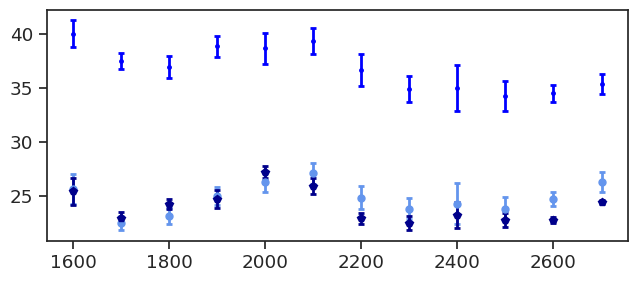

In [31]:
fig, ax = plt.subplots(1,1, figsize=(7.5,3), sharey=False)
sns.set_theme(style='ticks', palette='dark', font_scale=1.2)

for i in range(len(holo_files)):
    mask = density_pixel[i] > 0
    print(f"Relative error:\nPixel wise ({np.mean(fluctuation_pixel[i][mask])*100:0.1f} ± {np.std(fluctuation_pixel[i][mask])*100:0.1f})%")
    print(f"Disk wise  ({np.mean(fluctuation_disk[i][mask])*100:0.1f} ± {np.std(fluctuation_disk[i][mask])*100:0.1f})%")
    print(f"Cell wise  ({np.mean(fluctuation_cell[i][mask])*100:0.1f} ± {np.std(fluctuation_cell[i][mask])*100:0.1f})%\n")
    
lw = 2
ms = 5
h2_1=ax.errorbar(binned_density, mean_pixel, yerr=std_pixel, fmt=".", lw=lw, ms=ms,   capsize=2, capthick=2, label="pixel", color='blue')
h2_2=ax.errorbar(binned_density, mean_disk,  yerr=std_disk,  fmt="o", lw=lw, ms=ms,   capsize=2, capthick=2, label="disk",  color='cornflowerblue')
h2_3=ax.errorbar(binned_density, mean_cell,  yerr=std_cell,  fmt="p", lw=lw, ms=ms+1, capsize=2, capthick=2, label="cell",  color='darkblue')

In [32]:
# tomomonitor
# settings
stepsize = 2
steps = int((fmax_tomo - fmin_tomo)/stepsize) + 1

density_pixel = np.zeros([len(tomo_paths), steps])
density_disk  = np.zeros([len(tomo_paths), steps])
density_cell  = np.zeros([len(tomo_paths), steps])

h_mean_pixel = np.zeros([len(tomo_paths), steps])
h_mean_disk  = np.zeros([len(tomo_paths), steps])
h_mean_cell  = np.zeros([len(tomo_paths), steps])

fluctuation_pixel = np.zeros([len(tomo_paths), steps])
fluctuation_disk  = np.zeros([len(tomo_paths), steps])
fluctuation_cell  = np.zeros([len(tomo_paths), steps])

correlation_lenght = np.zeros([len(tomo_paths), fmax_tomo])

i = 0
for path, file in zip(tomo_paths, tomo_files):
    # steps = int(np.ceil((fmax_tomo[i] - fmin_tomo[i]) / stepsize))

    # import data
    h_tomo_full  = import_tomocube_stack(path, file, f_min=fmin_tomo, f_max=fmax_tomo, h_scaling=vox_to_um[0])[1]
    df_tomo_full = pd.read_csv(f"{path}/area_volume_filtered.csv")

    # disk wise data
    h_tomo = h_tomo_full[0:fmax_tomo-fmin_tomo:stepsize]
    hblur_tomo = np.zeros_like(h_tomo)
    df_tomo = pd.DataFrame()

    j = 0
    for frame in range(0, len(h_tomo_full)-1, stepsize):
        r_cell = average_cell_radius(df_tomo_full, frame, vox_to_um, blur_factor=rblur_tomo)
        hblur_tomo[j] = gaussian_filter(h_tomo[j], r_cell)

        df_tmp = df_tomo_full[df_tomo_full.frame == frame]
        df_tmp.loc[:,'frame'] = j
        df_tomo = pd.concat([df_tomo, df_tmp])
        j += 1
    
    # Compute fluctuation
    density_pixel[i], h_mean_pixel[i], fluctuation_pixel[i] = compute_flatness(h_tomo,     df_tomo)
    density_disk[i],  h_mean_disk[i],  fluctuation_disk[i]  = compute_flatness(hblur_tomo[:, r_cell:-r_cell, r_cell:-r_cell], df_tomo)
    density_cell[i],  h_mean_cell[i],  fluctuation_cell[i]  = compute_flatness_cellwise(df_tomo, fmin=df_tomo.frame.min(), fmax=df_tomo.frame.max()+1) 

    i += 1

In [33]:
density = density_pixel * 1e6 ## in [mm²]
bin_size = 100

# min_density = 1600
# max_density = 2700
# n_bins = int((max_density - min_density) / bin_size)
n_bins = int((density.max() - density.min()) / bin_size)

binned_density = np.zeros(n_bins)
mean_pixel, std_pixel = np.zeros(n_bins), np.zeros(n_bins)
mean_disk,  std_disk  = np.zeros(n_bins), np.zeros(n_bins)
mean_cell,  std_cell  = np.zeros(n_bins), np.zeros(n_bins)
mean_corr,  std_corr  = np.zeros(n_bins), np.zeros(n_bins)

for i in range(n_bins):
    mask = (density >= density.min() + i*bin_size) * (density < density.min() + (i+1)*bin_size)
    binned_density[i] = density.min() + (i+0.5)*bin_size

    mean_pixel[i] = np.mean(fluctuation_pixel[mask])*100
    mean_disk[i]  = np.mean(fluctuation_disk[mask])*100
    mean_cell[i]  = np.mean(fluctuation_cell[mask])*100

    std_pixel[i]  = (np.std(fluctuation_pixel[mask]) / np.sqrt(np.sum(mask)))*100
    std_disk[i]   = (np.std(fluctuation_disk[mask])  / np.sqrt(np.sum(mask)))*100
    std_cell[i]   = (np.std(fluctuation_cell[mask])  / np.sqrt(np.sum(mask)))*100

    #print(np.sum(mask))

In [ ]:
for i in range(len(tomo_files)):
    print(f"relative error:\Pixel wise ({np.mean(fluctuation_pixel[i])*100:0.1f} ± {np.std(fluctuation_pixel[i])*100:0.1f})%")
    print(f"Disk wise  ({np.mean(fluctuation_disk[i])*100:0.1f} ± {np.std(fluctuation_disk[i])*100:0.1f})%")
    print(f"Cell wise  ({np.mean(fluctuation_cell[i])*100:0.1f} ± {np.std(fluctuation_cell[i])*100:0.1f})%")
    
lw = 2
ms = 5
h3_1=ax.errorbar(binned_density, mean_pixel, yerr=std_pixel, fmt=".", lw=lw, ms=ms,   capsize=2, capthick=1, label="pixel", c='orangered')
h3_2=ax.errorbar(binned_density, mean_disk,  yerr=std_disk,  fmt="o", lw=lw, ms=ms,   capsize=2, capthick=1, label="disk",  c='coral')
h3_3=ax.errorbar(binned_density, mean_cell,  yerr=std_cell,  fmt="p", lw=lw, ms=ms+1, capsize=2, capthick=1, label="cell",  c='maroon')

ax.set(xlabel=r"$\rho_{cell} ~[mm^{-2}]$", ylabel=r"$\hat{\sigma}_{h,xy} ~[\%] $");

fig.tight_layout(rect=[0, 0, 0.85, 1.05])
ax.legend([h0, h2_1, h2_2, h2_3, h0, h0, h3_1, h3_2, h3_3],
          [r'$\hat{\sigma}_{h2,xy}$', 'pixel', 'disk', 'cell', '', r'$\hat{\sigma}_{h3,xy}$', 'pixel', 'disk', 'cell'],
           loc='upper center',
           bbox_to_anchor=(1.1, 1.1),
           frameon=False,
           alignment='center')
fig

relative error:\Pixel wise (30.5 ± 3.3)%
Disk wise  (19.0 ± 2.5)%
Cell wise  (19.4 ± 2.1)%


In [37]:
fig.savefig("../../figs/flatness/spatial_height_variation.png", dpi=300)